# Results

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import (validation_curve,
                                     learning_curve,
                                     TimeSeriesSplit,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     KFold)
from sklearn.metrics import r2_score

%matplotlib inline

plt.rcParams['font.size']=12
plt.rcParams['font.family']='Times new roman'

In [6]:
#Get data
data = pd.read_csv('master_df.csv', sep = ";")
data["date"] = pd.to_datetime(data["date"]) #Set date to datetime and as index
#data.set_index('date', inplace = True) #set date as index
#data.sort_index(inplace=True)

#Get ticker data
tickers = pd.read_csv("TickerNames_1956.csv")['0'].values

#Create ticker dataframe
index = []
for i in range(len(tickers)):
    index.append(i)
tickers_df = pd.DataFrame({'Index':index, 'Ticker':tickers}).reset_index(drop=True)
tickers_dict = tickers_df['Ticker'].to_dict()

#create tickers dictionary
tickers_dict = {value: key for key, value in tickers_dict.items()}

#drop extra index column
data = data.drop("Unnamed: 0", axis = 1)

## ElasticNet

### Technical and eod data only

We now train our model with the optimal hyperparameters from gridsearch and then test it on test data

In [7]:
#split data into X and Y
X = data.drop(["returns_pred","Market Cap"], axis = 1)

#get tickers as numbers to differentiate stocks
X['index_ticker']=X['Ticker'].map(tickers_dict)

#drop tickers and sentiment scores
X = X.drop(["Ticker", "LLM_score_sum", "LLM_score_mean"], axis = 1)

y = data["prev_returns"].copy()


In [8]:
X['date'] = pd.to_datetime(X['date'])

#Split the data into development (train & validation) and test
X_dev = X[X['date']<'2023-05-18'] 
X_test = X[X['date']>='2023-05-18']
y_dev =  y[:len(X_dev)]
y_test = y[len(X_dev):]
#sort values by date, descending
X_dev = X_dev.sort_values('date', ascending = True)
X_test = X_test.sort_values('date', ascending = True)

X.set_index('date', inplace = True)
X_dev.set_index('date', inplace = True)
X_test.set_index('date', inplace = True)


In [6]:
tscv = TimeSeriesSplit(n_splits=12, test_size = 19360)

In [7]:
all_train = []
all_val = []

#get index for train and validation splits from the development data
for train_index, val_index in tscv.split(X_dev):
    all_train.append(train_index)
    all_val.append(val_index)

In [8]:
l1_opt = 0.046415888336127774 #get optimal values from gridsearch
l2_opt =  0.5555555555555556 #get optimal values from gridsearch

In [9]:
start = time.time()

MSE = []
index_j = []

for j in tqdm(range(len(all_train))):
    index_j.append(j)
    pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                   StandardScaler(),
                   ElasticNet(alpha = l1_opt, l1_ratio = l1_opt))

    #split into 12-folds split by timeseries
    X_train, y_train = X_dev.iloc[all_train[j]], y_dev[all_train[j]]
    X_val, y_val = X_dev.iloc[all_val[j]], y_dev[all_val[j]]

    #train the model with the given set
    model = pipe_el.fit(X_train, y_train)

    #predict with validation set and find MSE
    ypred_val = model.predict(X_val)
    MSE.append(mse(y_val, ypred_val))

MSE_train = np.mean(MSE)

end = time.time()
elapsed_time = end-start
time_min = elapsed_time/60
time_h = time_min/60
print(time_min)
print("Time elapsed(min): ",time_min)

100%|██████████| 12/12 [11:02<00:00, 55.22s/it]

11.04423854748408
Time elapsed(min):  11.04423854748408


Nows it's time to test our test data!

In [ ]:
ypred_test_tech = model.predict(X_test)
mse_test_tech = mse(y_test, ypred_test_tech)

print("MSE on test data: ", mse_test_tech)
print('RMSE on test data ', np.sqrt(mse_test_tech))

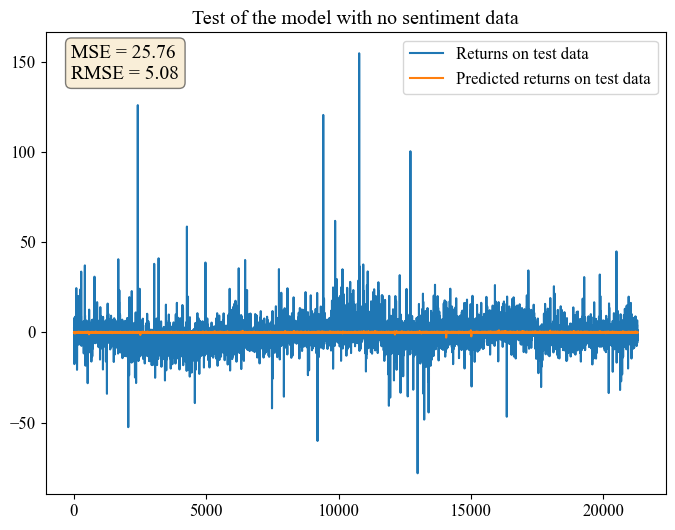

In [46]:
x_axis = np.linspace(0,len(y_test), len(y_test))
textstr = '\n'.join((
    f'MSE = {round(mse_test_tech,2)}',
    f'RMSE = {round(np.sqrt(mse_test_tech),2)}'))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.figure(figsize = (8,6))
plt.plot(x_axis, y_test, label = "Returns on test data")
plt.plot(x_axis, ypred_test_tech, label = "Predicted returns on test data")
plt.text(-100, 160, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title("Test of the model with no sentiment data")
plt.legend()
plt.show()

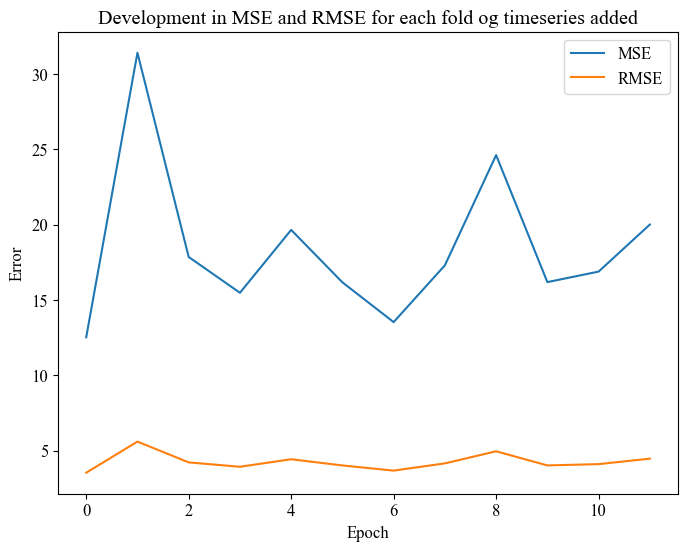

In [47]:
#plot learning curve - how does the model develop when adding more data in time series?
plt.figure(figsize = (8,6))
plt.plot(index_j, MSE, label = "MSE")
plt.plot(index_j, np.sqrt(MSE), label = "RMSE")
plt.title("Development in MSE and RMSE for each fold og timeseries added")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

### Technical and sentiment data

In [53]:
#Get data
data = pd.read_csv('master_df.csv', sep = ";")
data["date"] = pd.to_datetime(data["date"]) #Set date to datetime and as index
#data.set_index('date', inplace = True) #set date as index
#data.sort_index(inplace=True)

#Get ticker data
tickers = pd.read_csv("TickerNames_1956.csv")['0'].values

#Create ticker dataframe
index = []
for i in range(len(tickers)):
    index.append(i)
tickers_df = pd.DataFrame({'Index':index, 'Ticker':tickers}).reset_index(drop=True)
tickers_dict = tickers_df['Ticker'].to_dict()

#create tickers dictionary
tickers_dict = {value: key for key, value in tickers_dict.items()}

#drop extra index column
data = data.drop("Unnamed: 0", axis = 1)

In [54]:
#split data into X and Y
X = data.drop(["returns_pred","Market Cap"], axis = 1)

#get tickers as numbers to differentiate stocks
X['index_ticker']=X['Ticker'].map(tickers_dict)

#drop tickers and sentiment scores
X = X.drop(["Ticker"], axis = 1)

y = data["prev_returns"].copy()

In [55]:
X['date'] = pd.to_datetime(X['date'])

#Split the data into development (train & validation) and test
X_dev = X[X['date']<'2023-05-18'] 
X_test = X[X['date']>='2023-05-18']
y_dev =  y[:len(X_dev)]
y_test = y[len(X_dev):]
#sort values by date, descending
X_dev = X_dev.sort_values('date', ascending = True)
X_test = X_test.sort_values('date', ascending = True)

X.set_index('date', inplace = True)
X_dev.set_index('date', inplace = True)
X_test.set_index('date', inplace = True)

In [57]:
tscv = TimeSeriesSplit(n_splits=12, test_size = 19360)

In [58]:
all_train = []
all_val = []

#get index for train and validation splits from the development data
for train_index, val_index in tscv.split(X_dev):
    all_train.append(train_index)
    all_val.append(val_index)

In [59]:
l1_opt = 0.046415888336127774 #get optimal values from gridsearch
l2_opt =  0.5555555555555556 #get optimal values from gridsearch

In [44]:
start = time.time()
#training the model with time series cross validation

MSE_all = []
index_j_all = []

for j in tqdm(range(len(all_train))):
    index_j_all.append(j)
    pipe_el = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                   StandardScaler(),
                   ElasticNet(alpha = l1_opt, l1_ratio = l1_opt))

    #split into 12-folds split by timeseries
    X_train, y_train = X_dev.iloc[all_train[j]], y_dev[all_train[j]]
    X_val, y_val = X_dev.iloc[all_val[j]], y_dev[all_val[j]]

    #train the model with the given set
    model_all = pipe_el.fit(X_train, y_train)

    #predict with validation set and find MSE
    ypred_val = model_all.predict(X_val)
    MSE_all.append(mse(y_val, ypred_val))

MSE_train_all = np.mean(MSE)

end = time.time()
elapsed_time = end-start
time_min = elapsed_time/60
time_h = time_min/60
print(time_min)
print("Time elapsed(min): ",time_min)

100%|██████████| 12/12 [17:37<00:00, 88.14s/it] 

17.628972073396046
Time elapsed(min):  17.628972073396046


In [60]:
ypred_test_all = model_all.predict(X_test)
mse_test_all = mse(y_test, ypred_test_tech)

print("MSE on test data: ", mse_test_all)
print('RMSE on test data ', np.sqrt(mse_test_all))

MSE on test data:  25.76131204214049
RMSE on test data  5.0755602687920565


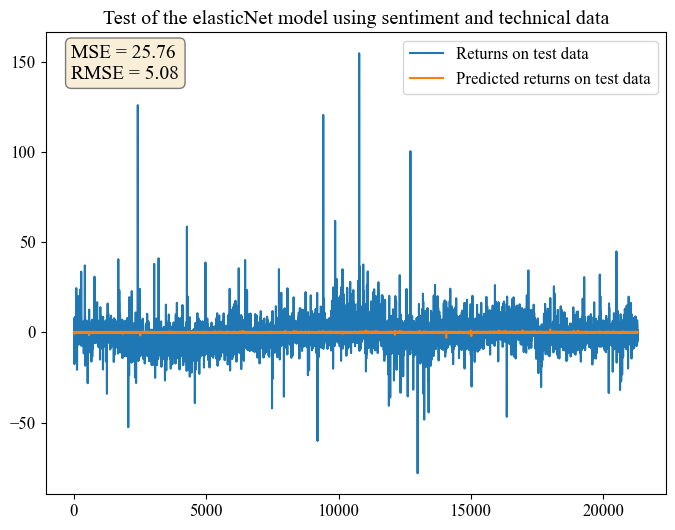

In [167]:
x_axis = np.linspace(0,len(y_test), len(y_test))
textstr = '\n'.join((
    f'MSE = {round(mse_test_all,2)}',
    f'RMSE = {round(np.sqrt(mse_test_all),2)}'))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.figure(figsize = (8,6))
plt.plot(x_axis, y_test, label = "Returns on test data")
plt.plot(x_axis, ypred_test_all, label = "Predicted returns on test data")
plt.text(-100, 160, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title("Test of the elasticNet model using sentiment and technical data")
plt.legend()
plt.savefig('Sentiment and technical test prediction.png')
plt.show()

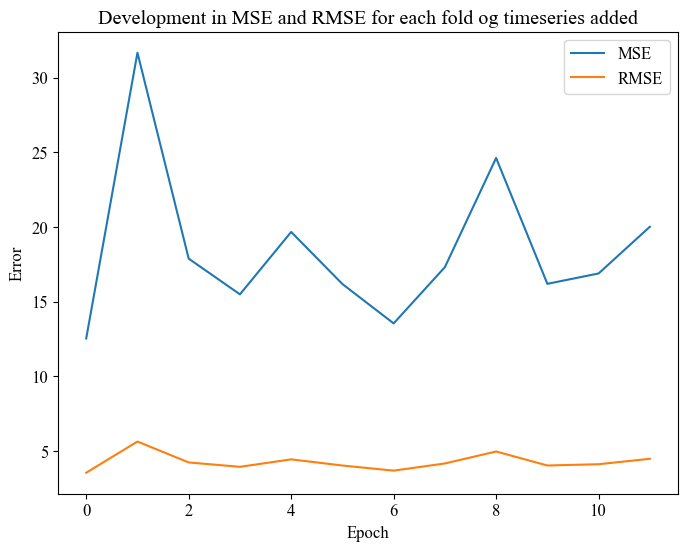

In [62]:
#plot learning curve - how does the model develop when adding more data in time series?
plt.figure(figsize = (8,6))
plt.plot(index_j, MSE_all, label = "MSE")
plt.plot(index_j, np.sqrt(MSE_all), label = "RMSE")
plt.title("Development in MSE and RMSE for each fold og timeseries added")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

### Sentiment data only

In [70]:
#Get data
data = pd.read_csv('master_df.csv', sep = ";")
data["date"] = pd.to_datetime(data["date"]) #Set date to datetime and as index
#data.set_index('date', inplace = True) #set date as index
#data.sort_index(inplace=True)

#Get ticker data
tickers = pd.read_csv("TickerNames_1956.csv")['0'].values

#Create ticker dataframe
index = []
for i in range(len(tickers)):
    index.append(i)
tickers_df = pd.DataFrame({'Index':index, 'Ticker':tickers}).reset_index(drop=True)
tickers_dict = tickers_df['Ticker'].to_dict()

#create tickers dictionary
tickers_dict = {value: key for key, value in tickers_dict.items()}

#drop extra index column
data = data.drop("Unnamed: 0", axis = 1)

In [71]:
#split data into X and Y
X = data.drop(["returns_pred","Market Cap"], axis = 1)

#get tickers as numbers to differentiate stocks
X['index_ticker']=X['Ticker'].map(tickers_dict)

X=X[['date','index_ticker','LLM_score_mean','LLM_score_sum']]

#drop tickers and sentiment scores

y = data["prev_returns"].copy()


In [72]:
X['date'] = pd.to_datetime(X['date'])

#Split the data into development (train & validation) and test
X_dev = X[X['date']<'2023-05-18'] 
X_test = X[X['date']>='2023-05-18']
y_dev =  y[:len(X_dev)]
y_test = y[len(X_dev):]
#sort values by date, descending
X_dev = X_dev.sort_values('date', ascending = True)
X_test = X_test.sort_values('date', ascending = True)

X.set_index('date', inplace = True)
X_dev.set_index('date', inplace = True)
X_test.set_index('date', inplace = True)


In [73]:
tscv = TimeSeriesSplit(n_splits=12, test_size = 19360)

In [74]:
all_train = []
all_val = []

#get index for train and validation splits from the development data
for train_index, val_index in tscv.split(X_dev):
    all_train.append(train_index)
    all_val.append(val_index)

In [75]:
#Create model pipeline with OLS
pipe_lin = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                       StandardScaler(),
                       LinearRegression())

In [78]:
start = time.time()
#training the model with time series cross validation

MSE_sent = []
index_i = []

for i in tqdm(range(len(all_train))):
    index_i.append(i)
    pipe_lin = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                           StandardScaler(),
                           LinearRegression())

    #split into 12-folds split by timeseries
    X_train, y_train = X_dev.iloc[all_train[i]], y_dev[all_train[i]]
    X_val, y_val = X_dev.iloc[all_val[i]], y_dev[all_val[i]]

    #train the model with the given set
    model_lin = pipe_lin.fit(X_train, y_train)

    #predict with validation set and find MSE
    ypred_val = model_lin.predict(X_val)
    MSE_sent.append(mse(y_val, ypred_val))
    
MSE.append(np.mean(MSE_sent))

end = time.time()
elapsed_time = end-start
time_min = elapsed_time/60
time_h = time_min/60
print(time_min)
print("Time elapsed(min): ",time_min)

100%|██████████| 12/12 [00:05<00:00,  2.31it/s]

0.08651514450709025
Time elapsed(min):  0.08651514450709025


In [82]:
ypred_test_sent = model_lin.predict(X_test)
mse_test_sent = mse(y_test, ypred_test_sent)

print("MSE sentiment only: ", mse_test_sent)
print("RMSE sentiment only: ", np.sqrt(mse_test_sent))

MSE sentiment only:  25.675283099083327
RMSE sentiment only:  5.0670783592799635


In [ ]:
x_axis = np.linspace(0,len(y_test), len(y_test))
textstr = '\n'.join((
    f'MSE = {round(mse_test_sent,2)}',
    f'RMSE = {round(np.sqrt(mse_test_sent),2)}'))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.figure(figsize = (8,6))
plt.plot(x_axis, y_test, label = "Returns on test data")
plt.plot(x_axis, ypred_test_sent, label = "Predicted returns on test data")
plt.text(-100, 160, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title("Test of the model with sentiment data")
plt.legend()
plt.show()

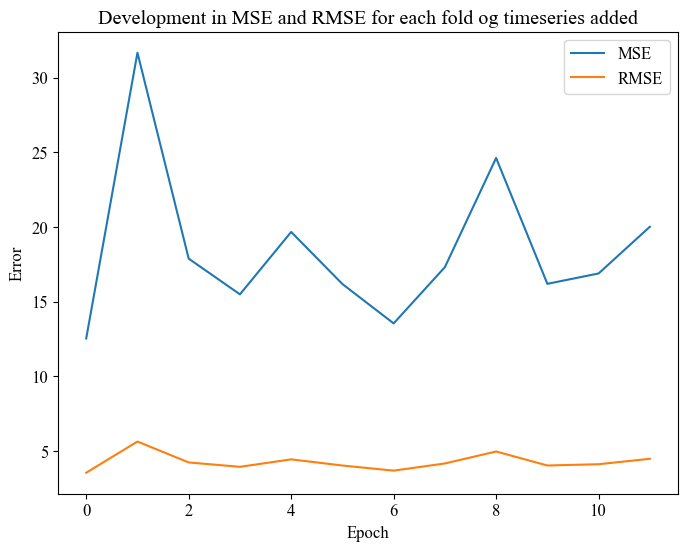

In [84]:
#plot learning curve - how does the model develop when adding more data in time series?
plt.figure(figsize = (8,6))
plt.plot(index_j, MSE_all, label = "MSE")
plt.plot(index_j, np.sqrt(MSE_all), label = "RMSE")
plt.title("Development in MSE and RMSE for each fold og timeseries added")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

## LASSO only

### Technical data only

In [159]:
#split data into X and Y
X = data.drop(["returns_pred","Market Cap"], axis = 1)

#get tickers as numbers to differentiate stocks
X['index_ticker']=X['Ticker'].map(tickers_dict)

#drop tickers and sentiment scores
X = X.drop(["Ticker", "LLM_score_sum", "LLM_score_mean"], axis = 1)

y = data["prev_returns"].copy()


In [160]:
X['date'] = pd.to_datetime(X['date'])

#Split the data into development (train & validation) and test
X_dev = X[X['date']<'2023-05-18'] 
X_test = X[X['date']>='2023-05-18']
y_dev =  y[:len(X_dev)]
y_test = y[len(X_dev):]
#sort values by date, descending
X_dev = X_dev.sort_values('date', ascending = True)
X_test = X_test.sort_values('date', ascending = True)

X.set_index('date', inplace = True)
X_dev.set_index('date', inplace = True)
X_test.set_index('date', inplace = True)


In [161]:
tscv = TimeSeriesSplit(n_splits=12, test_size = 19360)

In [162]:
all_train = []
all_val = []

#get index for train and validation splits from the development data
for train_index, val_index in tscv.split(X_dev):
    all_train.append(train_index)
    all_val.append(val_index)

In [163]:
start_time = time.time()

lambdas =  np.logspace(-4, -2, 12)

pipe_lasso = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    StandardScaler(),
    Lasso(random_state=1),
)

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',# scoring='neg_mean_squared_error',                 
                     cv=tscv)

mean_values = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
                         'test': pd.DataFrame(-test_scores).mean(1), 
                         'lambda': pd.DataFrame(lambdas).mean(1)}, axis =1)

# plot curves
pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(lambdas, name='lambda'))\
    .plot(logx=True, logy=True)

plt.show()

end_time = time.time()

elapsed_time = end_time - start_time
time_min = elapsed_time/60
time_h = time_min/60

print("Time elapsed(min): ",time_min)

KeyboardInterrupt: 

# Splitting randomly instead of TimseriesSplit - NOT PART OF THE PROJECT
We did this to test what happened if we did not used timesSeriesSplit. Data leakage was strongly observed

## Eod data only

In [156]:
#Get data
data = pd.read_csv('master_df.csv', sep = ";")
data["date"] = pd.to_datetime(data["date"]) #Set date to datetime and as index
#data.set_index('date', inplace = True) #set date as index
#data.sort_index(inplace=True)

#Get ticker data
tickers = pd.read_csv("tickers_list_news.csv")['0'].values

#Create ticker dataframe
index = []
for i in range(len(tickers)):
    index.append(i)
tickers_df = pd.DataFrame({'Index':index, 'Ticker':tickers}).reset_index(drop=True)
tickers_dict = tickers_df['Ticker'].to_dict()

#create tickers dictionary
tickers_dict = {value: key for key, value in tickers_dict.items()}

#drop extra index column
data = data.drop("Unnamed: 0", axis = 1)

In [157]:
#split data into X and Y
X = data.drop(["returns_pred","Market Cap"], axis = 1)

#get tickers as numbers to differentiate stocks
X['index_ticker']=X['Ticker'].map(tickers_dict)

#drop tickers and sentiment scores
X = X.drop(["Ticker", "LLM_score_sum", "LLM_score_mean"], axis = 1)

y = data["prev_returns"].copy()

X.set_index('date', inplace = True)

In [158]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

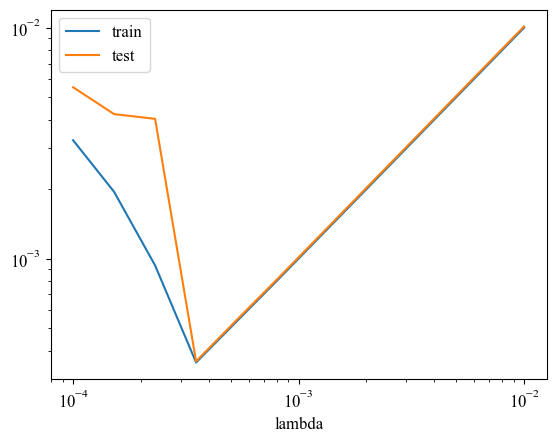

Time elapsed(min):  14.138646634419759


In [102]:
start_time = time.time()

from sklearn.model_selection import validation_curve
lambdas =  np.logspace(-4, -2, 12)

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',# scoring='neg_mean_squared_error',                 
                     cv=10)

mean_values = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
                         'test': pd.DataFrame(-test_scores).mean(1), 
                         'lambda': pd.DataFrame(lambdas).mean(1)}, axis =1)

# plot curves
pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(lambdas, name='lambda'))\
    .plot(logx=True, logy=True)

plt.show()

end_time = time.time()

elapsed_time = end_time - start_time
time_min = elapsed_time/60
time_h = time_min/60

print("Time elapsed(min): ",time_min)

In [108]:
scores = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)

scores.to_csv('Validation Lasso Eod random shuffle.csv')

idx_train = np.argmin(scores["train"])
idx_test = np.argmin(scores["test"])

print("Best lambda for test: ", idx_test)
print('Best lambda for train', idx_train)
print("lambda: ", lambdas[3])

Best lambda for test:  3
Best lambda for train 3
lambda:  0.0003511191734215131


Now lets train and test our model with the given value of lambda above

In [148]:
start = time.time()

l1_opt = 0.0003511191734215131
X_dev = X_dev.reset_index(drop = True)
y_dev = y_dev.reset_index(drop = True)

kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))

MSE_eod_shuffle_val = []
MSE_eod_shuffle_train = []

for train_idx, val_idx in tqdm(folds):
    pipe_lasso = make_pipeline(
        PolynomialFeatures(degree=3, include_bias=False),
        StandardScaler(),
        Lasso(alpha=l1_opt, random_state=1))

    #Create dataset into folds
    X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
    X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx]

    #train the model with the given set
    model = pipe_lasso.fit(X_train, y_train)

    #predict with validation set and find MSE
    ypred_val = model.predict(X_val)
    MSE_eod_shuffle_val.append(mse(y_val, ypred_val))
        
    #predict with validation set and find MSE
    ypred_train = model.predict(X_train)
    MSE_eod_shuffle_train.append(mse(y_train, ypred_train))



100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


In [149]:
ypred_test_eod_shuffle = model.predict(X_test)
mse_test_eod_shuffle = mse(y_test, ypred_test_eod_shuffle)

print("MSE on test data: ", mse_test_eod_shuffle)
print('RMSE on test data ', np.sqrt(mse_test_eod_shuffle))

MSE on test data:  1.1444116135643166e-07
RMSE on test data  0.00033829153308416053


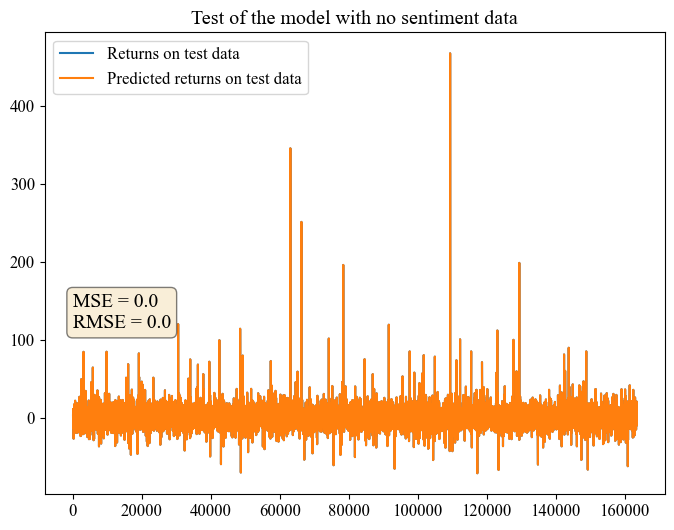

In [150]:
x_axis = np.linspace(0,len(y_test), len(y_test))
textstr = '\n'.join((
    f'MSE = {round(mse_test_eod_shuffle,2)}',
    f'RMSE = {round(np.sqrt(mse_test_eod_shuffle),2)}'))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.figure(figsize = (8,6))
plt.plot(x_axis, y_test, label = "Returns on test data")
plt.plot(x_axis, ypred_test_eod_shuffle, label = "Predicted returns on test data")
plt.text(-100, 160, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title("Test of the model with no sentiment data")
plt.legend()
plt.show()

In [151]:
pd.DataFrame(zip(ypred_test_eod_shuffle,y_test))

,0,1
0,3.466699,3.466956
1,-0.373569,-0.373599
2,-3.466515,-3.466777
3,2.563914,2.564103
4,5.999676,6.000121
...,...,...
163265,-1.336860,-1.336962
163266,-1.954249,-1.954397
163267,3.054437,3.054662
163268,1.735231,1.735358
